In [21]:
import pandas as pd
from idaes.core.solvers import get_solver
from pyomo.environ import ConcreteModel, RangeSet, Var, log10, minimize


In [22]:
df = pd.read_excel("data for parmest.xlsx", sheet_name = "Fe only")
# df = df[df['ascorbic (g/L)'] != 0]
index = df.shape[0]
idx_list = RangeSet(0,index-1)
print(df)

    ascorbic (g/L)        pH  dosage          E         D      logD     w
0             1.50  0.759084       5   3.354839  0.034713 -1.459508  0.01
1             1.50  0.922433       5   3.870968  0.040268 -1.395035  0.01
2             1.50  1.243918       5   6.967742  0.074896 -1.125542  0.01
3             1.50  1.454186       5  17.548387  0.212833 -0.671962  0.01
4             1.50  1.598420       5  25.290323  0.338515 -0.470422  0.01
5             1.50  1.812164       5  32.774194  0.487524 -0.312004  0.01
6             1.25  0.759084       5   6.967742  0.074896 -1.125542  0.01
7             1.25  0.898104       5   8.000000  0.086957 -1.060698  0.01
8             1.25  1.235229       5  20.387097  0.256078 -0.591628  0.01
9             1.25  1.369036       5  30.451613  0.437848 -0.358677  0.01
10            1.25  1.589731       5  39.483871  0.652452 -0.185451  0.01
11            1.25  1.765245       5  45.677419  0.840855 -0.075279  0.01
12            1.00  0.750395       5  

In [23]:
m = ConcreteModel()

m.pH = Var(idx_list)
m.dosage = Var(idx_list)
m.logD_exp = Var(idx_list)
m.logD_model = Var(idx_list)
m.ascorbic = Var(idx_list)

for i in idx_list:
    m.pH[i].fix(df['pH'][i])
    m.dosage[i].fix(df['dosage'][i])
    m.logD_exp[i].fix(df['logD'][i])
    m.ascorbic[i].fix(df['ascorbic (g/L)'][i])

ascorbic_list = df['ascorbic (g/L)'].unique()

# variable_list = [1,2]

m.a = Var(ascorbic_list, initialize=0.1, bounds=(-10,10))
m.b = Var(ascorbic_list, initialize=0.1, bounds=(0, 10))
m.c = Var(ascorbic_list, initialize=-0.1, bounds=(-10,10))
m.d = Var(ascorbic_list, initialize=0.1, bounds=(0,10))


@m.Constraint(idx_list)
def logD_model_rule(m,i):
    asc_index = df['ascorbic (g/L)'][i]
    return m.logD_model[i] == (m.a[asc_index]+m.b[asc_index]*m.dosage[i])*m.pH[i] + (m.c[asc_index]+m.d[asc_index]*log10(m.dosage[i]))
@m.Expression()
def SSE(m):
    return sum(((m.logD_exp[i] - m.logD_model[i])**2)*df['w'][i] for i in idx_list)

@m.Objective(sense=minimize)
def objective_rule(m):
    return m.SSE

solver=get_solver('ipopt_v2')
solver.solve(m, tee=True)


Ipopt 3.13.2: linear_solver="ma57"
max_iter=200
nlp_scaling_method="gradient-based"
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collect

{'Problem': [{'Lower bound': None, 'Upper bound': 0.6290687026449885, 'Number of objectives': 1, 'Number of constraints': nan, 'Number of variables': nan, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.convergenceCriteriaSatisfied'}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [24]:
m.logD_model_rule.pprint()

logD_model_rule : Size=42, Index=[0:41], Active=True
    Key : Lower : Body                                                                                           : Upper : Active
      0 :   0.0 :         logD_model[0] - (c[1.5] + d[1.5]*log10(dosage[0]) + (a[1.5] + b[1.5]*dosage[0])*pH[0]) :   0.0 :   True
      1 :   0.0 :         logD_model[1] - (c[1.5] + d[1.5]*log10(dosage[1]) + (a[1.5] + b[1.5]*dosage[1])*pH[1]) :   0.0 :   True
      2 :   0.0 :         logD_model[2] - (c[1.5] + d[1.5]*log10(dosage[2]) + (a[1.5] + b[1.5]*dosage[2])*pH[2]) :   0.0 :   True
      3 :   0.0 :         logD_model[3] - (c[1.5] + d[1.5]*log10(dosage[3]) + (a[1.5] + b[1.5]*dosage[3])*pH[3]) :   0.0 :   True
      4 :   0.0 :         logD_model[4] - (c[1.5] + d[1.5]*log10(dosage[4]) + (a[1.5] + b[1.5]*dosage[4])*pH[4]) :   0.0 :   True
      5 :   0.0 :         logD_model[5] - (c[1.5] + d[1.5]*log10(dosage[5]) + (a[1.5] + b[1.5]*dosage[5])*pH[5]) :   0.0 :   True
      6 :   0.0 :     logD_model[6] -

In [25]:
m.a.pprint()
m.b.pprint()
m.c.pprint()
m.d.pprint()

a : Size=7, Index={0.75, 1.5, 0.5, 1.25, 1.0, 0.25, 0.0}
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
     0.0 :   -10 : -0.9886229720998142 :    10 : False : False :  Reals
    0.25 :   -10 : -2.1827422017038027 :    10 : False : False :  Reals
     0.5 :   -10 : -2.2201209972807923 :    10 : False : False :  Reals
    0.75 :   -10 :  -2.244213404142086 :    10 : False : False :  Reals
     1.0 :   -10 : -2.2171598918838322 :    10 : False : False :  Reals
    1.25 :   -10 :  -2.239575057954914 :    10 : False : False :  Reals
     1.5 :   -10 : -2.2871064935622645 :    10 : False : False :  Reals
b : Size=7, Index={0.75, 1.5, 0.5, 1.25, 1.0, 0.25, 0.0}
    Key  : Lower : Value                 : Upper : Fixed : Stale : Domain
     0.0 :     0 : 6.386413869563257e-07 :    10 : False : False :  Reals
    0.25 :     0 :    0.6645323305751135 :    10 : False : False :  Reals
     0.5 :     0 :    0.6457642428299454 :    10 : False : False :  Reals
    0.75 :    

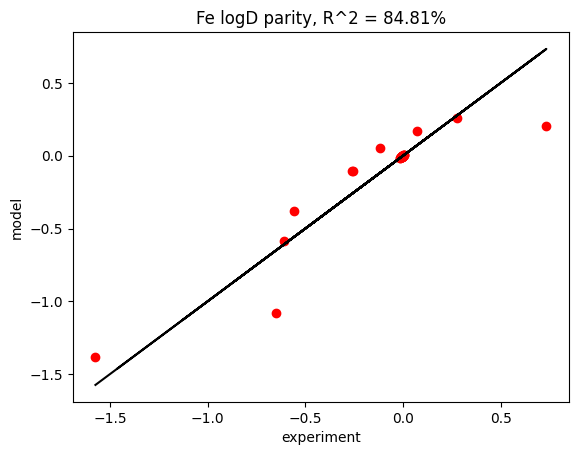

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error


plt.figure()
x = [m.logD_exp[i].value*df['w'][i] for i in idx_list]
y = [m.logD_model[i].value*df['w'][i] for i in idx_list]
x_ideal = [m.logD_exp[i].value for i in idx_list]
plt.plot(x_ideal, x_ideal, label='y=x (ideal)', linestyle='-', color='black')

for i in idx_list:
    plt.scatter(x[i], y[i], color='red', label='5% DEHPA 10% TBP')
plt.xlabel('experiment')
plt.ylabel('model')
plt.title(f"Fe logD parity, R^2 = {r2_score(x, y)*100:.2f}%")

plt.show()

In [27]:
ascorbic_list =df['ascorbic (g/L)'].unique()

In [28]:
ascorbic_list

array([1.5 , 1.25, 1.  , 0.75, 0.5 , 0.25, 0.  ])

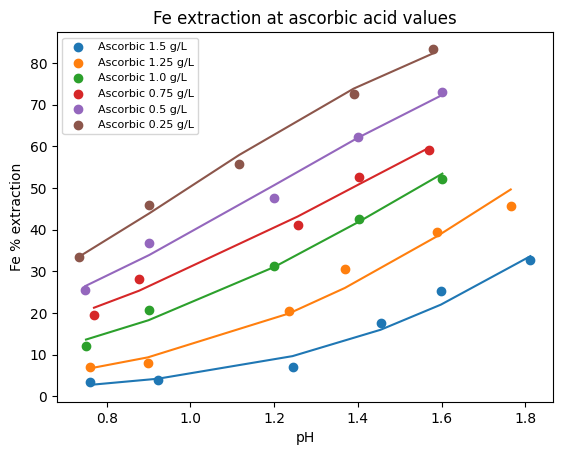

In [29]:
for s in ascorbic_list:
    if s!=0:
        pH_list = df['pH'][df['ascorbic (g/L)'] == s].values
        logD_exp_list = df['logD'][df['ascorbic (g/L)'] == s].values
        logD_model_list = [(m.a[s]()+m.b[s]()*5)*pH + (m.c[s]()+m.d[s]()*log10(5)) for pH in pH_list]
        plt.scatter(pH_list, [100*10**d/(1+10**d) for d in logD_exp_list], label=f'Ascorbic {s} g/L')
        plt.plot(pH_list, [100*10**d/(1+10**d) for d in logD_model_list])
        plt.xlabel('pH')
        plt.ylabel('Fe % extraction')
        plt.title('Fe extraction at ascorbic acid values')
        plt.legend(fontsize=8)

In [30]:
df_0 = df[df['ascorbic (g/L)'] == 0]
df_0

,ascorbic (g/L),pH,dosage,E,D,logD,w
32,0.0,0.50,1,8.43,0.276182,-0.558804,1.0
33,0.0,0.50,2,15.59,0.554081,-0.256427,1.0
34,0.0,0.50,3,20.18,0.758457,-0.120069,1.0
35,0.0,0.50,4,28.24,1.180602,0.072104,1.0
36,0.0,0.50,5,38.65,1.889976,0.276456,1.0
37,0.0,0.19,2,64.37,5.419871,0.733989,1.0
38,0.0,0.50,2,15.43,0.547357,-0.261729,1.0
39,0.0,0.99,2,7.57,0.245699,-0.609596,1.0
40,0.0,1.49,2,6.91,0.222688,-0.652304,1.0
41,0.0,1.79,2,0.88,0.026634,-1.574557,1.0


C:\Users\apdgh\AppData\Local\Temp\ipykernel_27704\2864324876.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend(fontsize=8)
C:\Users\apdgh\AppData\Local\Temp\ipykernel_27704\2864324876.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(fontsize=8)


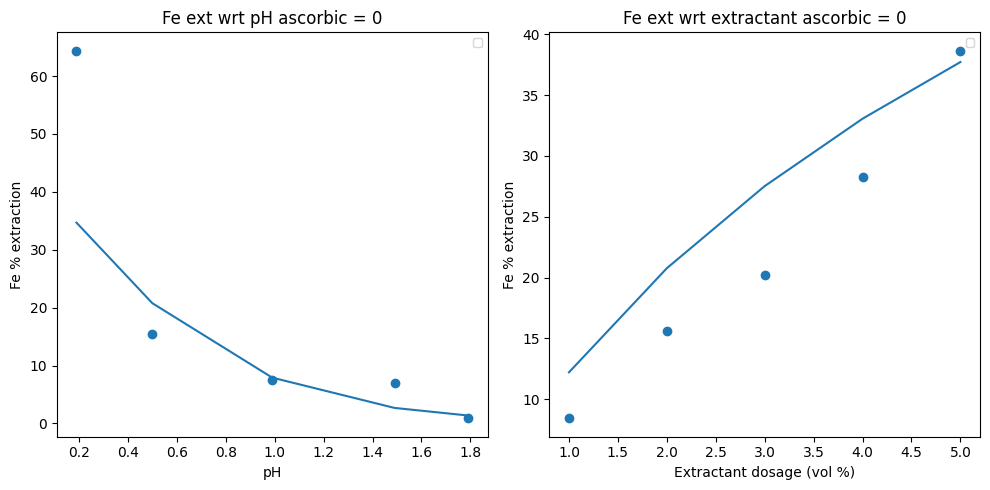

In [31]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_0_idx = df_0.index.tolist()
pH_0 = [df_0['pH'][i] for i in RangeSet(37,41)]
logD_exp_0 = [df_0['logD'][i] for i in RangeSet(37,41)]
logD_model_0 = [(m.a[0]()+m.b[0]()*2)*pH + (m.c[0]()+m.d[0]()*log10(2)) for pH in pH_0]
ax[0].scatter(pH_0, [100*10**d/(3+10**d) for d in logD_exp_0])
ax[0].plot(pH_0, [100*10**d/(3+10**d) for d in logD_model_0])
# plt.scatter(pH_0, [d for d in logD_exp_0])
# plt.plot(pH_0, [d for d in logD_model_0])
ax[0].set_xlabel('pH')
ax[0].set_ylabel('Fe % extraction')
ax[0].set_title('Fe ext wrt pH ascorbic = 0')
ax[0].legend(fontsize=8)

ext_1 = [df_0['dosage'][i] for i in RangeSet(32,36)]
logD_exp_1 = [df_0['logD'][i] for i in RangeSet(32,36)]
logD_model_1 = [(m.a[0]()+m.b[0]()*e)*0.5 + (m.c[0]()+m.d[0]()*log10(e)) for e in ext_1]
ax[1].scatter(ext_1, [100*10**d/(3+10**d) for d in logD_exp_1])
ax[1].plot(ext_1, [100*10**d/(3+10**d) for d in logD_model_1])
ax[1].set_xlabel('Extractant dosage (vol %)')
ax[1].set_ylabel('Fe % extraction')
ax[1].set_title('Fe ext wrt extractant ascorbic = 0')
ax[1].legend(fontsize=8)

plt.tight_layout()

In [40]:
# plt.plot(pH_0, logD_model_0)
# plt.scatter(pH_0, logD_exp_0)

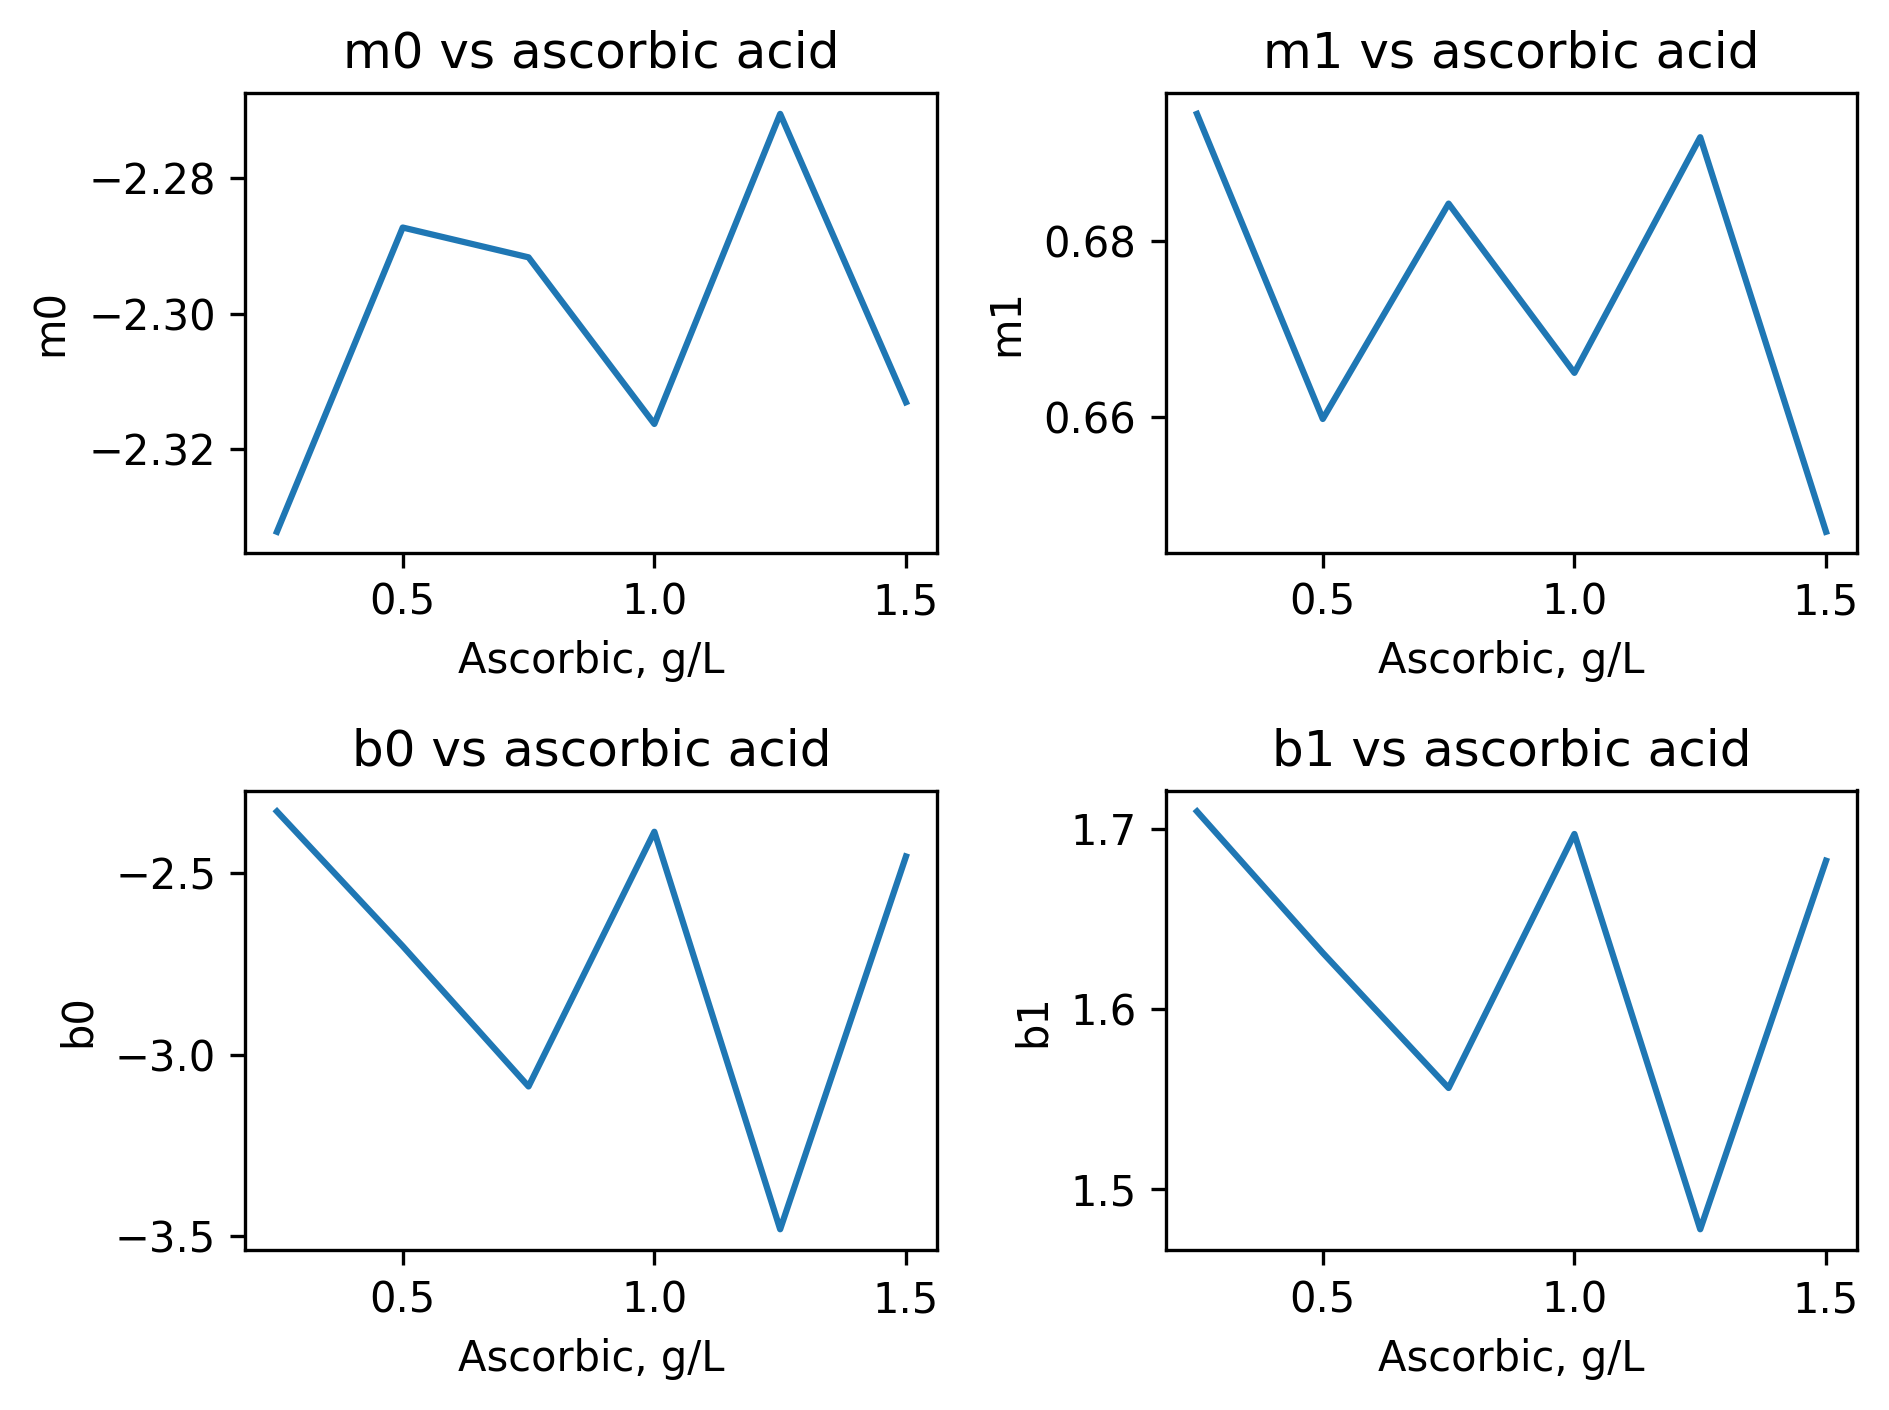

In [41]:
fig, ax = plt.subplots(2,2,dpi=300)

ax[0,0].plot(ascorbic_list, m.a[:]())
ax[0,0].set_xlabel('Ascorbic, g/L')
ax[0,0].set_ylabel('m0')
ax[0,0].set_title('m0 vs ascorbic acid')

ax[0,1].plot(ascorbic_list, m.b[:]())
ax[0,1].set_xlabel('Ascorbic, g/L')
ax[0,1].set_ylabel('m1')
ax[0,1].set_title('m1 vs ascorbic acid')

ax[1,0].plot(ascorbic_list, m.c[:]())
ax[1,0].set_xlabel('Ascorbic, g/L')
ax[1,0].set_ylabel('b0')
ax[1,0].set_title('b0 vs ascorbic acid')

ax[1,1].plot(ascorbic_list, m.d[:]())
ax[1,1].set_xlabel('Ascorbic, g/L')
ax[1,1].set_ylabel('b1')
ax[1,1].set_title('b1 vs ascorbic acid')

plt.tight_layout()